# Fake news decetion

In [3]:
import re
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evaluate
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, PunktTokenizer
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    TrainingArguments,
    Trainer,
    BertTokenizer,
    BertModel
)

from datasets import load_dataset, DatasetDict
import datasets

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

import umap

Per il progetto è stata utilizzata la seguente versione di transformer:


```
!pip install transformers==4.26.1
```



Nel caso di errori nel caricamento del dataset tramite file csv,\
utilizzare il seguente comando:


```
!pip install -U datasets
```



### Caricamento dataset

In [ ]:
dataset = load_dataset('csv', data_files='liar_dataset.csv')

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
train_testvalid = dataset['train'].train_test_split(test_size=0.2)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)

In [ ]:
dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'validation': test_valid['train']})

In alternativa si può caricare il dataset direttamente da HuggingFace (in cui manca la parte di preprocessing) tramite il comando:


```
dataset = load_dataset("chengxuphd/liar2")
```



### Pre-processing

Divisione del dataset iniziale in sotto dataset separati e preprocessing

In [ ]:
statement_train, y_train_label = dataset["train"]["statement"], dataset["train"]["label"]
statement_val, y_val_label = dataset["validation"]["statement"], dataset["validation"]["label"]
statement_test, y_test_label = dataset["test"]["statement"], dataset["test"]["label"]

Encoding degli speaker

In [ ]:
speaker_list = list(set(dataset['train']['speaker'] + dataset['validation']['speaker'] + dataset['test']['speaker']))

In [ ]:
encoder_speaker = LabelEncoder()
encoder_speaker.fit(speaker_list)

LabelEncoder()

In [ ]:
speaker_train_label = encoder_speaker.transform(dataset["train"]["speaker"])
speaker_val_label = encoder_speaker.transform(dataset["validation"]["speaker"])
speaker_test_label = encoder_speaker.transform(dataset["test"]["speaker"])

In [ ]:
scaler_speaker = StandardScaler()
speaker_train_scaled = scaler_speaker.fit_transform(speaker_train_label.reshape(-1, 1))
speaker_val_scaled = scaler_speaker.transform(speaker_val_label.reshape(-1, 1))
speaker_test_scaled = scaler_speaker.transform(speaker_test_label.reshape(-1, 1))

Encoding dei subject

In [ ]:
subject_list = list(set(dataset["train"]["subject"] + dataset["validation"]["subject"] + dataset["test"]["subject"]))

In [ ]:
encoder_subject = LabelEncoder()
encoder_subject.fit(subject_list)

LabelEncoder()

In [ ]:
subject_train_label = encoder_subject.transform(dataset["train"]["subject"])
subject_val_label = encoder_subject.transform(dataset["validation"]["subject"])
subject_test_label = encoder_subject.transform(dataset["test"]["subject"])

In [ ]:
scaler_subject = StandardScaler()
subject_train_scaled = scaler_subject.fit_transform(subject_train_label.reshape(-1, 1))
subject_val_scaled = scaler_subject.transform(subject_val_label.reshape(-1, 1))
subject_test_scaled = scaler_subject.transform(subject_test_label.reshape(-1, 1))

Encoding date

In [ ]:
year_list = list(set(dataset["train"]["date"] + dataset["validation"]["date"] + dataset["test"]["date"]))
year_list = pd.to_datetime(year_list).year

In [ ]:
encoder_year = MinMaxScaler()
encoder_year.fit(np.array(year_list).reshape(-1, 1))

MinMaxScaler()

In [ ]:
year_train = np.array(pd.to_datetime(dataset["train"]["date"]).year)
year_val = np.array(pd.to_datetime(dataset["validation"]["date"]).year)
year_test = np.array(pd.to_datetime(dataset["test"]["date"]).year)

In [ ]:
year_train_label = encoder_year.transform(year_train.reshape(-1, 1)).flatten().tolist()
year_val_label = encoder_year.transform(year_val.reshape(-1, 1)).flatten().tolist()
year_test_label = encoder_year.transform(year_test.reshape(-1, 1)).flatten().tolist()

### Tokenizer

In [ ]:
model_name = 'google-bert/bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def tokenize(examples):
    return tokenizer(examples["statement"], padding="max_length", truncation=True)

In [ ]:
statement_dataset = dataset.select_columns(column_names=['statement', 'label'])

In [ ]:
statement_dataset = statement_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/18074 [00:00<?, ? examples/s]

Map:   0%|          | 0/2260 [00:00<?, ? examples/s]

Map:   0%|          | 0/2259 [00:00<?, ? examples/s]

In [ ]:
partial = statement_dataset['test'][:1000]
lengths = [len(tokenizer.encode(text)) for text in partial['statement']]

In [ ]:
print(f"Analisi lunghezza su {len(lengths)} statements:")
print(f"- Lunghezza media: {np.mean(lengths):.0f} token")
print(f"- Lunghezza massima: {max(lengths)} token")

Analisi lunghezza su 1000 statements:
- Lunghezza media: 25 token
- Lunghezza massima: 80 token


In [ ]:
max_length = 128

In [ ]:
train_encodings = tokenizer(statement_dataset['train']['statement'], padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")
val_encodings = tokenizer(statement_dataset['validation']['statement'], padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")
test_encodings = tokenizer(statement_dataset['test']['statement'], padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")

### Embedding

In [ ]:
def embedding_function(encodings):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)
  model.eval()

  dset = TensorDataset(encodings["input_ids"], encodings["attention_mask"])
  loader = DataLoader(dset, batch_size=32)

  cls_embeddings = []

  with torch.no_grad():
      for batch in loader:
          input_ids_b, attn_b = batch[0].to(device), batch[1].to(device)
          outputs = model(input_ids=input_ids_b, attention_mask=attn_b)
          cls_embeddings.append(outputs.pooler_output.cpu())

  return torch.cat(cls_embeddings, dim=0)

In [ ]:
train_embeddings = embedding_function(train_encodings)
val_embeddings = embedding_function(val_encodings)
test_embeddings = embedding_function(test_encodings)

In [ ]:
classes = len(np.unique(y_train_label))

In [ ]:
y_train_encoded = tf.keras.utils.to_categorical(y_train_label, num_classes=classes)
y_val_encoded = tf.keras.utils.to_categorical(y_val_label, num_classes=classes)
y_test_encoded = tf.keras.utils.to_categorical(y_test_label, num_classes=classes)

### Classificatore
Confronto tra diversi modelli e architetture per valutare quale possa ottenere risultati

In [ ]:
input_shape = train_embeddings[0].shape[0]

#### Classificatore rete neurale

In [ ]:
classifier = Sequential([
    Dense(128, activation='relu', input_shape=(input_shape, )),
    Dense(64, activation='relu'),
    Dense(classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
classifier.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = classifier.fit(
    train_embeddings, y_train_encoded,
    validation_data=(val_embeddings, y_val_encoded),
    epochs=10,
    batch_size=32,
)

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.2990 - loss: 1.6691 - val_accuracy: 0.3010 - val_loss: 1.6434
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3081 - loss: 1.6373 - val_accuracy: 0.3006 - val_loss: 1.6336
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3132 - loss: 1.6241 - val_accuracy: 0.3094 - val_loss: 1.6214
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3137 - loss: 1.6151 - val_accuracy: 0.3081 - val_loss: 1.6139
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3140 - loss: 1.6131 - val_accuracy: 0.3077 - val_loss: 1.6191
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3117 - loss: 1.6058 - val_accuracy: 0.3032 - val_loss: 1.6145
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3236 - loss: 1.6052 - val_accuracy: 0.3130 - val_loss: 1.6089
Epoch 8/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3154 - loss: 1.6055 - val_accuracy: 0

In [ ]:
def predict(test, label, model):
  predictions = np.argmax(model.predict(test), axis=1).tolist()
  print(f'Accuracy: {np.round(accuracy_score(label, predictions)*100, 2)}%')
  return predictions

In [ ]:
prediction = predict(test_embeddings, y_test_label, classifier)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 31.99%


In [ ]:
def predict_aggregated(test, label, model):
  predictions = np.argmax(model.predict(test), axis=1).tolist()
  predictions = [0 if label in [0, 1, 2] else 1 for label in predictions]
  label = [0 if label in [0, 1, 2] else 1 for label in label]
  print(f'Accuracy: {np.round(accuracy_score(label, predictions)*100, 2)}%')
  return predictions

In [ ]:
prediction_agg = predict_aggregated(test_embeddings, y_test_label, classifier)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 68.19%


In [ ]:
def plot_confusion_matrix(label, predition, name, classes):
  cm = confusion_matrix(label, predition)
  if classes == 2:
    disp = ConfusionMatrixDisplay(cm, display_labels=["False","True"])
  else:
    disp = ConfusionMatrixDisplay(cm, display_labels=["pants_on_fire", "false", "mostly_false", "half_true", "mostly_true", "true"])
  disp.plot(cmap="Blues", xticks_rotation=45)
  plt.title(name)
  plt.show()

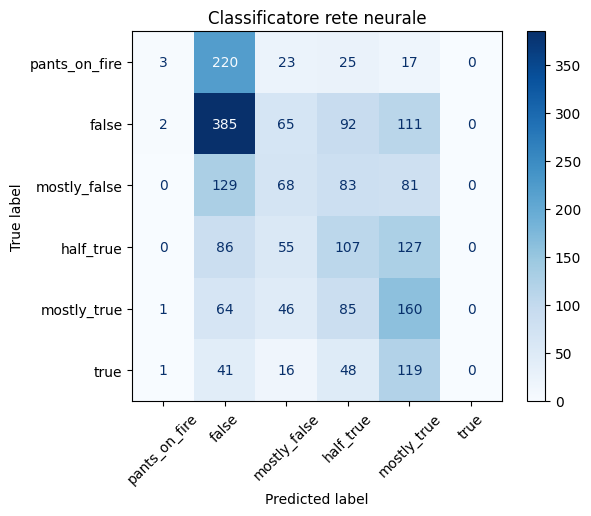

In [ ]:
plot_confusion_matrix(y_test_label, prediction, "Classificatore rete neurale", classes)

In [ ]:
test_label_agg = [0 if label in [0, 1, 2] else 1 for label in y_test_label]

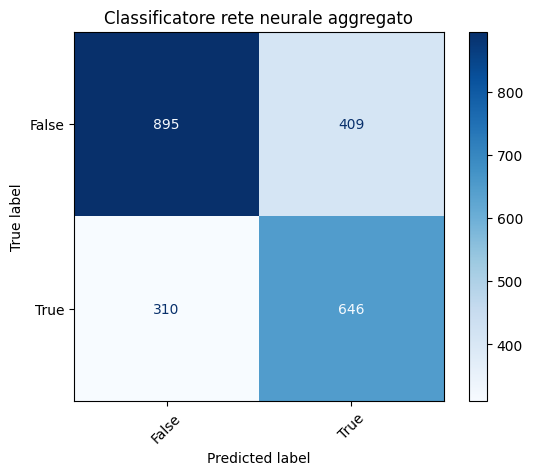

In [ ]:
plot_confusion_matrix(test_label_agg, prediction_agg, "Classificatore rete neurale aggregato", 2)

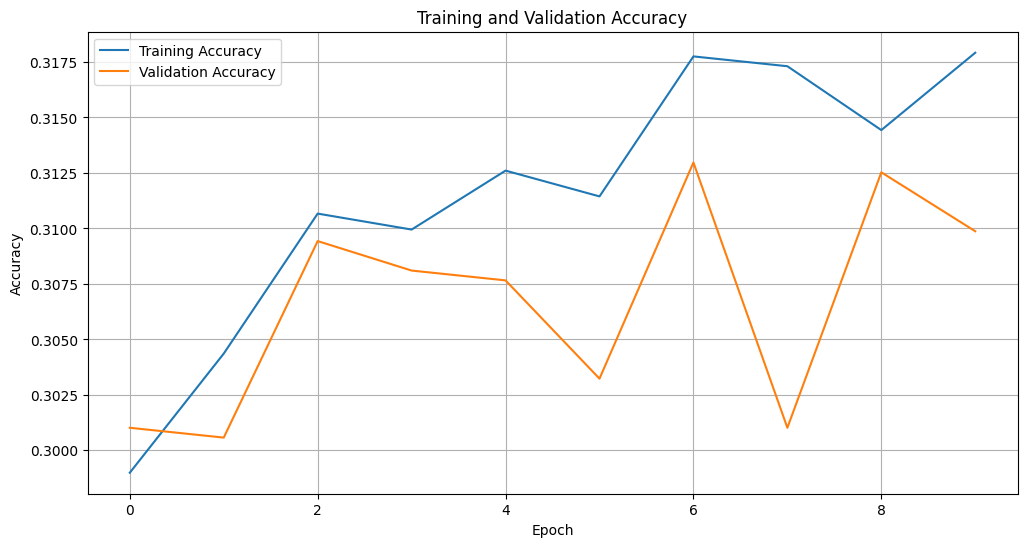

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

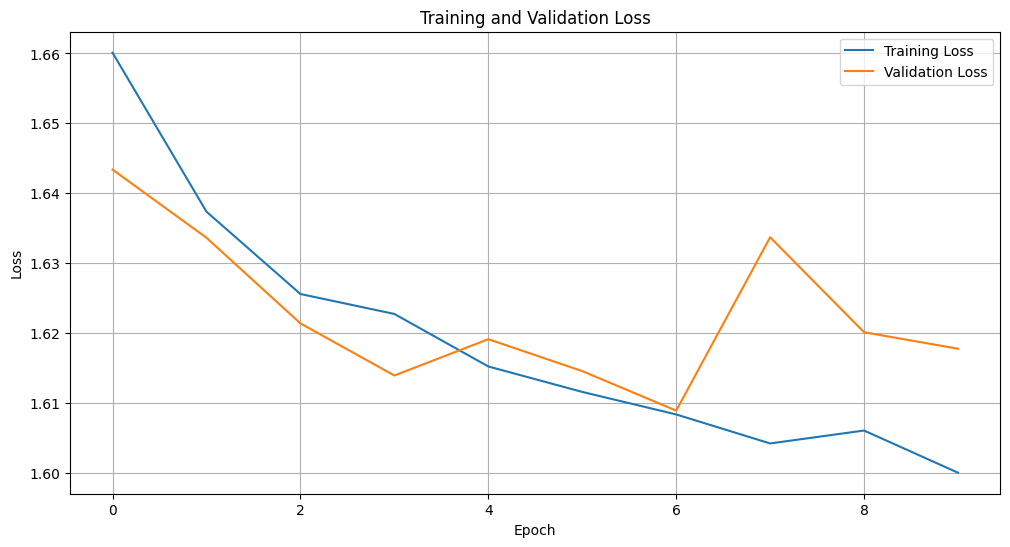

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

#### Classificatore rete neurale (con maggiore profondità)

In [ ]:
classifier_complete = Sequential([
    Dense(256, activation='relu', input_shape=(input_shape,)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
classifier_complete.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_complete = classifier_complete.fit(
    train_embeddings, y_train_encoded,
    validation_data=(val_embeddings, y_val_encoded),
    epochs=10,
    batch_size=32,
)

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.2646 - loss: 1.8117 - val_accuracy: 0.3081 - val_loss: 1.6571
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.3009 - loss: 1.6604 - val_accuracy: 0.3037 - val_loss: 1.6674
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3082 - loss: 1.6421 - val_accuracy: 0.2793 - val_loss: 1.6952
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3105 - loss: 1.6349 - val_accuracy: 0.3085 - val_loss: 1.6187
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3136 - loss: 1.6217 - val_accuracy: 0.3125 - val_loss: 1.6260
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3134 - loss: 1.6179 - val_accuracy: 0.3187 - val_loss: 1.6068
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3137 - loss: 1.6184 - val_accuracy: 0.2908 - val_loss: 1.6844
Epoch 8/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3098 - loss: 1.6220 - val_accuracy: 0.

In [ ]:
prediction_complete = predict(test_embeddings, y_test_label, classifier_complete)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 29.56%


In [ ]:
prediction_complete_agg = predict_aggregated(test_embeddings, y_test_label, classifier_complete)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 65.66%


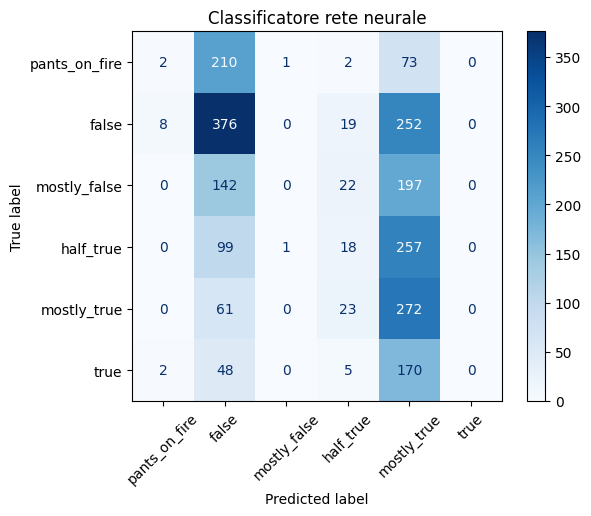

In [ ]:
plot_confusion_matrix(y_test_label, prediction_complete, "Classificatore rete neurale", classes)

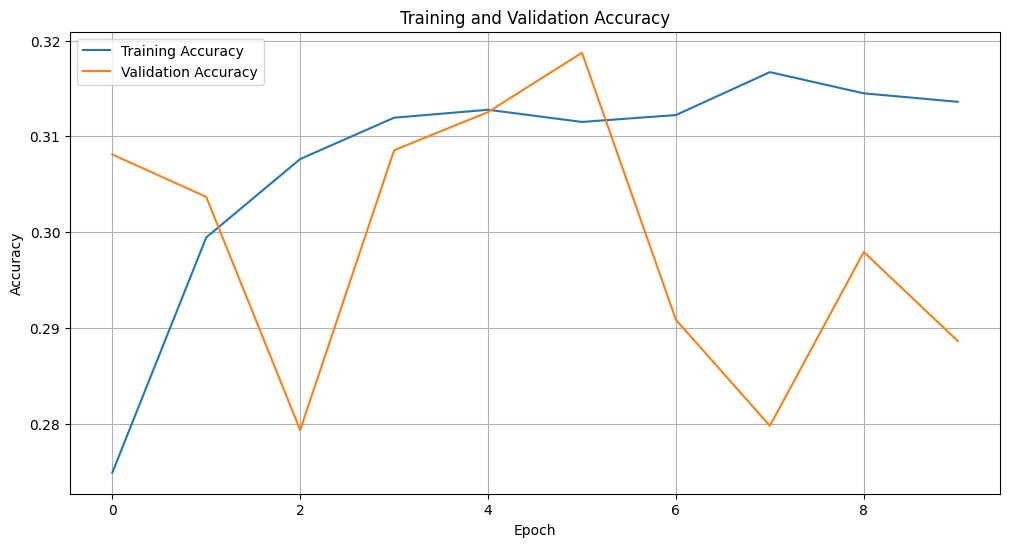

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history_complete.history['accuracy'], label='Training Accuracy')
plt.plot(history_complete.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

#### Random forest

In [ ]:
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

In [ ]:
rf_classifier.fit(train_embeddings, y_train_encoded)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
rf_pred = rf_classifier.predict(test_embeddings)

In [ ]:
predictions_rd = np.argmax(rf_pred, axis=1).tolist()
print(f'Accuracy: {np.round(accuracy_score(y_test_label, predictions_rd)*100, 2)}%')

Accuracy: 13.1%


In [ ]:
rf_classifier_optimized = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

In [ ]:
rf_classifier_optimized.fit(train_embeddings, y_train_encoded)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [ ]:
rf_optimized_pred = rf_classifier_optimized.predict(test_embeddings)

In [ ]:
predictions_optimized_rd = np.argmax(rf_optimized_pred, axis=1).tolist()
print(f'Accuracy: {np.round(accuracy_score(y_test_label, predictions_optimized_rd)*100, 2)}%')

Accuracy: 13.41%


### Riduzione dimensionalità (PCA)

In [ ]:
pca = PCA(n_components=50)
train_embeddings_pca = pca.fit_transform(train_embeddings)

In [ ]:
val_embeddings_pca = pca.transform(val_embeddings)
test_embeddings_pca = pca.transform(test_embeddings)

In [ ]:
input_shape_pca = train_embeddings_pca[0].shape[0]

In [ ]:
classifier_pca = Sequential([
    Dense(128, activation='relu', input_shape=(input_shape_pca, )),
    Dense(64, activation='relu'),
    Dense(classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
classifier_pca.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
classifier_pca.fit(
    train_embeddings_pca, y_train_encoded,
    validation_data=(val_embeddings_pca, y_val_encoded),
    epochs=10,
    batch_size=32,
)

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2863 - loss: 1.7015 - val_accuracy: 0.3134 - val_loss: 1.6222
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3312 - loss: 1.5928 - val_accuracy: 0.3094 - val_loss: 1.6155
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3301 - loss: 1.5832 - val_accuracy: 0.3178 - val_loss: 1.6121
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3428 - loss: 1.5657 - val_accuracy: 0.3280 - val_loss: 1.6067
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3471 - loss: 1.5509 - val_accuracy: 0.3218 - val_loss: 1.6094
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3620 - loss: 1.5330 - val_accuracy: 0.3192 - val_loss: 1.6125
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3641 - loss: 1.5242 - val_accuracy: 0.3293 - val_loss: 1.6119
Epoch 8/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3791 - loss: 1.5011 - val_accuracy: 0.

In [ ]:
prediction_pca = predict(test_embeddings_pca, y_test_label, classifier_pca)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 33.14%


In [ ]:
prediction_pca_agg = predict_aggregated(test_embeddings_pca, y_test_label, classifier_pca)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 67.08%


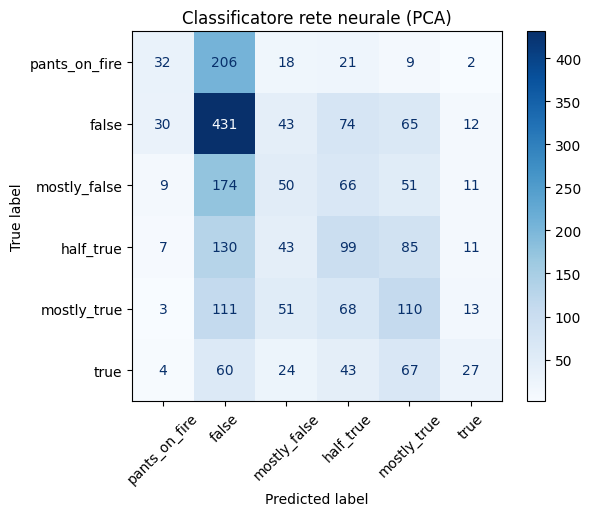

In [ ]:
plot_confusion_matrix(y_test_label, prediction_pca, "Classificatore rete neurale (PCA)", classes)

In [ ]:
pca2 = PCA(n_components=(192))
train_embeddings_pca2 = pca2.fit_transform(train_embeddings)

In [ ]:
val_embeddings_pca2 = pca2.transform(val_embeddings)
test_embeddings_pca2 = pca2.transform(test_embeddings)

In [ ]:
input_shape_pca2 = train_embeddings_pca2[0].shape[0]

In [ ]:
classifier_pca2 = Sequential([
    Dense(128, activation='relu', input_shape=(input_shape_pca2, )),
    Dense(64, activation='relu'),
    Dense(classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
classifier_pca2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
classifier_pca2.fit(
    train_embeddings_pca2, y_train_encoded,
    validation_data=(val_embeddings_pca2, y_val_encoded),
    epochs=10,
    batch_size=32,
)

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2869 - loss: 1.6875 - val_accuracy: 0.3161 - val_loss: 1.6085
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3381 - loss: 1.5676 - val_accuracy: 0.3249 - val_loss: 1.6009
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3540 - loss: 1.5414 - val_accuracy: 0.3285 - val_loss: 1.5942
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3741 - loss: 1.5080 - val_accuracy: 0.3249 - val_loss: 1.6009
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3924 - loss: 1.4770 - val_accuracy: 0.3192 - val_loss: 1.6019
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4112 - loss: 1.4491 - val_accuracy: 0.3165 - val_loss: 1.6217
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4240 - loss: 1.4222 - val_accuracy: 0.3196 - val_loss: 1.6262
Epoch 8/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4471 - loss: 1.3824 - val_accuracy: 0.

In [ ]:
prediction_pca2 = predict(test_embeddings_pca2, y_test_label, classifier_pca2)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 31.68%


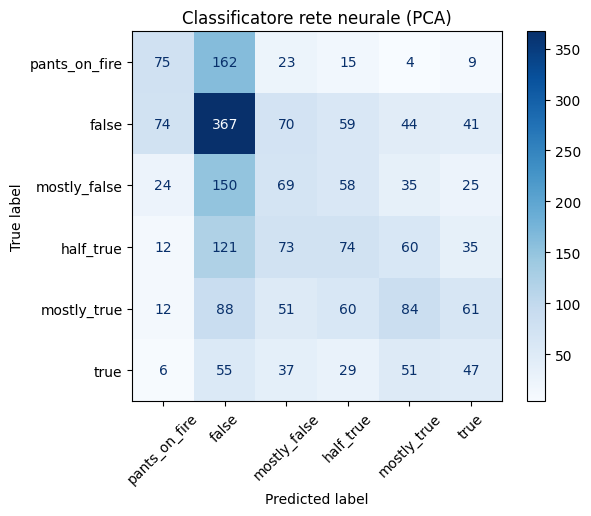

In [ ]:
plot_confusion_matrix(y_test_label, prediction_pca2, "Classificatore rete neurale (PCA)", classes)

### Riduzione dimenisonalità (UMAP)

In [ ]:
umap_reducer = umap.UMAP(
    n_components=50,
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine',
    random_state=42
)
train_embeddings_umap = umap_reducer.fit_transform(train_embeddings)
val_embeddings_umap = umap_reducer.transform(val_embeddings)
test_embeddings_umap = umap_reducer.transform(test_embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
input_shape_umap = train_embeddings_umap[0].shape[0]

In [ ]:
classifier_umap = Sequential([
    Dense(128, activation='relu', input_shape=(input_shape_umap, )),
    Dense(64, activation='relu'),
    Dense(classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
classifier_umap.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
classifier_umap.fit(
    train_embeddings_umap, y_train_encoded,
    validation_data=(val_embeddings_umap, y_val_encoded),
    epochs=10,
    batch_size=32,
)

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2486 - loss: 2.0064 - val_accuracy: 0.2961 - val_loss: 1.7372
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2751 - loss: 1.7640 - val_accuracy: 0.2961 - val_loss: 1.7346
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2858 - loss: 1.7463 - val_accuracy: 0.2961 - val_loss: 1.7350
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2846 - loss: 1.7446 - val_accuracy: 0.2961 - val_loss: 1.7369
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2867 - loss: 1.7437 - val_accuracy: 0.2961 - val_loss: 1.7414
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2889 - loss: 1.7401 - val_accuracy: 0.2961 - val_loss: 1.7347
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2856 - loss: 1.7410 - val_accuracy: 0.2961 - val_loss: 1.7309
Epoch 8/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2905 - loss: 1.7352 - val_accuracy: 0.

In [ ]:
prediction_umap = predict(test_embeddings_umap, y_test_label, classifier_umap)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 27.35%


In [ ]:
prediction_umap_agg = predict_aggregated(test_embeddings_umap, y_test_label, classifier_umap)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 56.06%


### Classificatore con piu feature

In [ ]:
train_features_combined = np.concatenate((train_embeddings_pca,
                                          np.array(speaker_train_label).reshape(-1, 1),
                                          np.array(subject_train_label).reshape(-1, 1),
                                          np.array(year_train_label).reshape(-1, 1)), axis=1)

In [ ]:
train_features_combined = np.concatenate((train_embeddings_pca,
                                          speaker_train_scaled,
                                          subject_train_scaled,
                                          np.array(year_train_label).reshape(-1, 1)), axis=1)

val_features_combined = np.concatenate((val_embeddings_pca,
                                        speaker_val_scaled,
                                        subject_val_scaled,
                                        np.array(year_val_label).reshape(-1, 1)), axis=1)

test_features_combined = np.concatenate((test_embeddings_pca,
                                         speaker_test_scaled,
                                         subject_test_scaled,
                                         np.array(year_test_label).reshape(-1, 1)), axis=1)

In [ ]:
input_shape_improved = train_features_combined[0].shape[0]

In [ ]:
classifier_combined = Sequential([
    Dense(128, activation='relu', input_shape=(input_shape_improved, )),
    Dense(64, activation='relu'),
    Dense(classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
classifier_combined.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_combined = classifier_combined.fit(
    train_features_combined, y_train_encoded,
    validation_data=(val_features_combined, y_val_encoded),
    epochs=10,
    batch_size=32,
)

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4160 - loss: 1.4322 - val_accuracy: 0.3147 - val_loss: 1.6231
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4258 - loss: 1.4271 - val_accuracy: 0.3152 - val_loss: 1.6253
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4308 - loss: 1.4030 - val_accuracy: 0.3152 - val_loss: 1.6368
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4388 - loss: 1.3851 - val_accuracy: 0.3112 - val_loss: 1.6377
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4476 - loss: 1.3786 - val_accuracy: 0.3121 - val_loss: 1.6590
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4591 - loss: 1.3505 - val_accuracy: 0.3019 - val_loss: 1.6680
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4647 - loss: 1.3351 - val_accuracy: 0.2997 - val_loss: 1.6768
Epoch 8/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4631 - loss: 1.3319 - val_accuracy: 0.

In [ ]:
prediction_pca = predict(test_features_combined, y_test_label, classifier_combined)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 31.19%


In [ ]:
prediction_pca_agg = predict_aggregated(test_features_combined, y_test_label, classifier_combined)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 66.99%


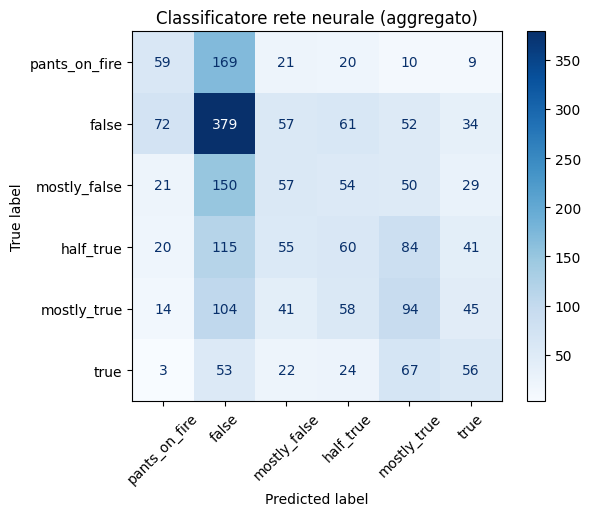

In [ ]:
plot_confusion_matrix(y_test_label, prediction_pca, "Classificatore rete neurale (aggregato)", classes)

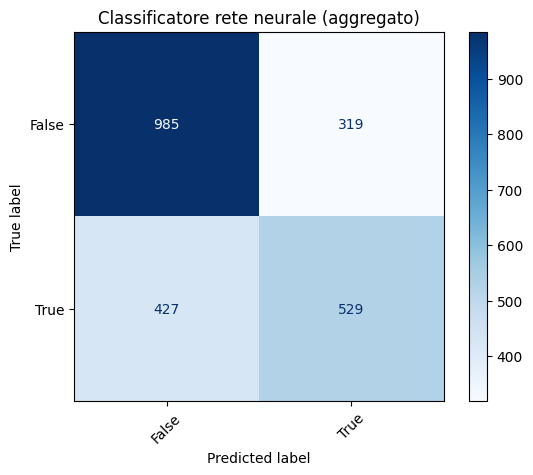

In [ ]:
plot_confusion_matrix(test_label_agg, prediction_pca_agg, "Classificatore rete neurale (aggregato)", 2)

### BERT finetune

#### Solo feature "statement"

In [4]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
def tokenize(examples):
    return tokenizer(examples["statement"], padding="max_length", truncation=True)

In [ ]:
minimal_dataset = dataset.select_columns(column_names=["statement", "label"])

In [ ]:
statement_train_tokenized = minimal_dataset["train"].map(tokenize, batched=True)
statement_val_tokenized = minimal_dataset["validation"].map(tokenize, batched=True)
statement_test_tokenized = minimal_dataset["test"].map(tokenize, batched=True)

Map:   0%|          | 0/18369 [00:00<?, ? examples/s]

Map:   0%|          | 0/2297 [00:00<?, ? examples/s]

Map:   0%|          | 0/2296 [00:00<?, ? examples/s]

In [5]:
model = AutoModelForSequenceClassification.from_pretrained(
    "google-bert/bert-base-uncased",
    num_labels=6
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="fake_news_classifier",
    eval_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    num_train_epochs=3,
    report_to="none",
)

In [ ]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=statement_train_tokenized,
    eval_dataset=statement_val_tokenized,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.562100,1.555284,0.350022
2,1.393800,1.591260,0.357858
3,1.143400,1.803518,0.336091


TrainOutput(global_step=1725, training_loss=1.3208418340268342, metrics={'train_runtime': 5325.2093, 'train_samples_per_second': 10.348, 'train_steps_per_second': 0.324, 'total_flos': 1.4499781659777024e+16, 'train_loss': 1.3208418340268342, 'epoch': 3.0})

In [ ]:
result = trainer.predict(statement_test_tokenized)
predictions = result.predictions.argmax(axis=-1)

In [ ]:
print(f'Accuracy: {np.round(accuracy_score(statement_test_tokenized["label"], predictions)*100, 2)}%')

Accuracy: 35.71%


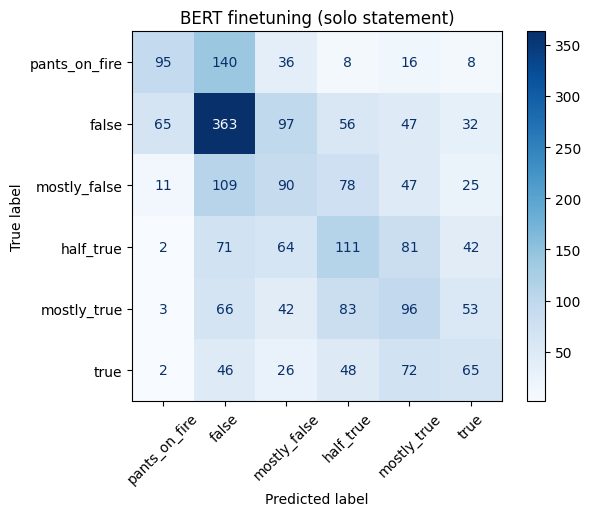

In [ ]:
cm = confusion_matrix(dataset["test"]["label"], predictions)
disp = ConfusionMatrixDisplay(cm, display_labels=["pants_on_fire", "false", "mostly_false", "half_true", "mostly_true", "true"])
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("BERT finetuning (solo statement)")
plt.show()

In [ ]:
labels = np.unique(dataset["test"]["label"])

In [ ]:
predictions_agg = [0 if label in [0, 1, 2] else 1 for label in predictions]
labels_agg = [0 if label in [0, 1, 2] else 1 for label in labels]

In [ ]:
print(f'Accuracy valori aggregati: {np.round(accuracy_score(labels_agg, predictions_agg)*100, 2)}%')

Accuracy valori aggregati: 72.17%


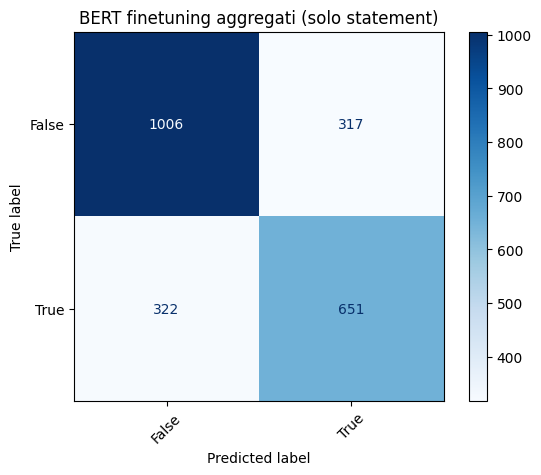

In [ ]:
cm = confusion_matrix(labels_agg, predictions_agg)
disp = ConfusionMatrixDisplay(cm, display_labels=["False","True"])
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("BERT finetuning aggregati (solo statement)")
plt.show()

#### Features aggiuntive

In [ ]:
def concatenate_fields(example):
    return {
        "statement": ("Statement: " + str(example["statement"]) +
                      " Speaker: " + str(example["speaker_description"]) +
                      " Subject: " + str(example["subject"]) +
                      ". Date: " + str(example["date"])),
        "label": example["label"]
    }

In [ ]:
minimal_dataset_combined = dataset.map(concatenate_fields, remove_columns=[col for col in dataset["train"].features if col not in ["statement", "label"]])

Map:   0%|          | 0/18369 [00:00<?, ? examples/s]

Map:   0%|          | 0/2297 [00:00<?, ? examples/s]

Map:   0%|          | 0/2296 [00:00<?, ? examples/s]

In [ ]:
statement_combined_train_tokenized = minimal_dataset_combined["train"].map(tokenize, batched=True)
statement_combined_val_tokenized = minimal_dataset_combined["validation"].map(tokenize, batched=True)
statement_combined_test_tokenized = minimal_dataset_combined["test"].map(tokenize, batched=True)

Map:   0%|          | 0/18369 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
    output_dir="fake_news_classifier",
    eval_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    num_train_epochs=3,
    report_to="none",
    fp16=True
)

In [ ]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=statement_combined_train_tokenized,
    eval_dataset=statement_combined_val_tokenized,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.562800,1.509399,0.366565
2,1.435400,1.473037,0.388768
3,1.261900,1.572337,0.388768


TrainOutput(global_step=1725, training_loss=1.3869796266417573, metrics={'train_runtime': 1368.2777, 'train_samples_per_second': 40.275, 'train_steps_per_second': 1.261, 'total_flos': 1.4499781659777024e+16, 'train_loss': 1.3869796266417573, 'epoch': 3.0})

In [ ]:
result = trainer.predict(statement_combined_test_tokenized)
predictions = result.predictions.argmax(axis=-1)

In [ ]:
print(f'Accuracy: {np.round(accuracy_score(statement_combined_test_tokenized["label"], predictions)*100, 2)}%')

Accuracy: 37.98%


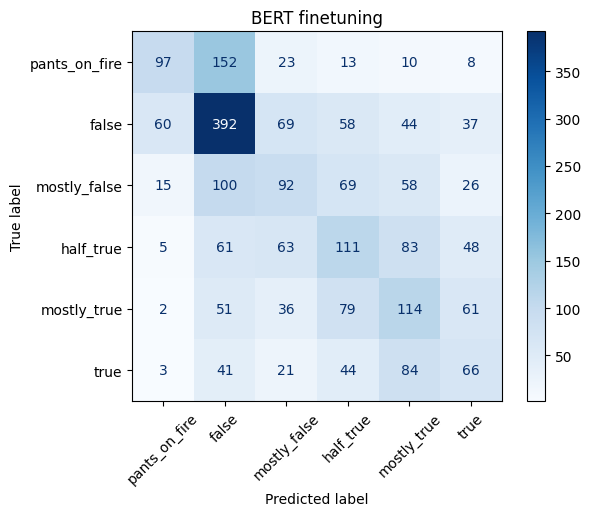

In [ ]:
cm = confusion_matrix(dataset["test"]["label"], predictions)
disp = ConfusionMatrixDisplay(cm, display_labels=["pants_on_fire", "false", "mostly_false", "half_true", "mostly_true", "true"])
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("BERT finetuning")
plt.show()

In [ ]:
labels = np.unique(dataset["test"]["label"])

In [ ]:
predictions_agg = [0 if label in [0, 1, 2] else 1 for label in predictions]
labels_agg = [0 if label in [0, 1, 2] else 1 for label in dataset["test"]["label"]]

In [ ]:
print(f'Accuracy valori aggregati: {np.round(accuracy_score(labels_agg, predictions_agg)*100, 2)}%')

Accuracy valori aggregati: 73.61%


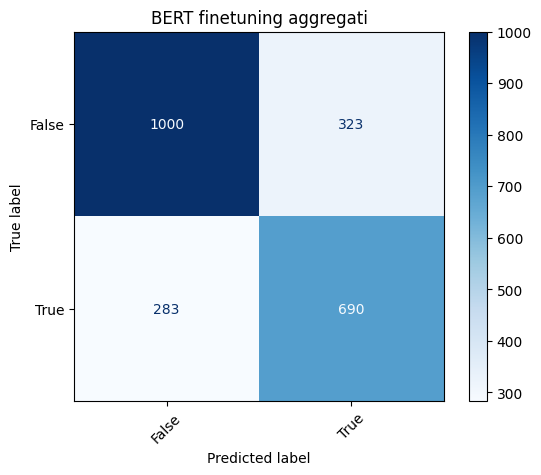

In [ ]:
cm = confusion_matrix(labels_agg, predictions_agg)
disp = ConfusionMatrixDisplay(cm, display_labels=["False","True"])
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("BERT finetuning aggregati")
plt.show()